# Setup & imports

In [13]:
%pip -q install "gymnasium[atari,accept-rom-license]" stable-baselines3[extra] ale-py shimmy

Note: you may need to restart the kernel to use updated packages.


In [14]:
import os, time, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed

In [15]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)
print("ALE registered ✅")

ALE registered ✅


In [16]:
ENV_ID = "ALE/Tennis-v5"
TOTAL_TIMESTEPS = 300_000
EVAL_EPISODES = 5
SEEDS = [0, 1, 2]

LOG_DIR = "./logs_tennis"
MODELS_DIR = "./models_tennis"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [17]:
def make_env(env_id=ENV_ID, seed=0):
    def _init():
        env = gym.make(env_id)
        env = Monitor(env)
        env = AtariWrapper(env)  # preprocess Atari standard (resize/frameskip/clip/...)
        env.reset(seed=seed)
        env.action_space.seed(seed)
        return env
    return _init

# Environnement pour DQN (single env - off-policy)
def make_vec_env_dqn(seed=0, n_stack=4):
    set_random_seed(seed)
    venv = DummyVecEnv([make_env(seed=seed)])
    venv = VecFrameStack(venv, n_stack=n_stack)
    return venv

# Environnement pour PPO (single env - on-policy avec buffer)
def make_vec_env_ppo(seed=0, n_stack=4):
    set_random_seed(seed)
    venv = DummyVecEnv([make_env(seed=seed)])
    venv = VecFrameStack(venv, n_stack=n_stack)
    return venv

# Environnement pour A2C (multi-env parallèles - optimal pour A2C)
def make_vec_env_a2c(seed=0, n_envs=4, n_stack=4):
    """A2C performe mieux avec plusieurs environnements parallèles"""
    set_random_seed(seed)
    venv = DummyVecEnv([make_env(seed=seed + i) for i in range(n_envs)])
    venv = VecFrameStack(venv, n_stack=n_stack)
    return venv

In [18]:
# venv = make_vec_env(seed=0)
# obs = venv.reset()
# print("obs shape:", obs.shape)   # (1, 4, 84, 84) en général
# print("action space:", venv.action_space)

In [19]:
from stable_baselines3.common.callbacks import BaseCallback
from tqdm.auto import tqdm

class EvalCallbackSimple(BaseCallback):
    def __init__(self, eval_env, eval_freq=20_000, n_eval_episodes=10, seed=0, verbose=0, total_timesteps=None):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.seed = seed
        self.history = []  # list of dicts
        self.last_eval = -1  # timestep de la dernière évaluation
        self.total_timesteps = total_timesteps
        self.pbar = None

    def _on_training_start(self) -> None:
        """Créer la barre de progression au début de l'entraînement"""
        if self.total_timesteps is not None:
            self.pbar = tqdm(total=self.total_timesteps, desc=f"Training (seed {self.seed})", 
                           unit="steps", dynamic_ncols=True)
            self.pbar.set_postfix({"last_reward": "N/A"})

    def _on_step(self) -> bool:
        # Mettre à jour la barre de progression
        if self.pbar is not None:
            self.pbar.n = self.num_timesteps
            self.pbar.refresh()
        
        # Évaluation périodique basée sur num_timesteps (pas n_calls)
        if self.num_timesteps >= self.last_eval + self.eval_freq:
            self.last_eval = self.num_timesteps
            print(f"\n[EVAL] t={self.num_timesteps}")
            mean_r, std_r = evaluate_policy(
                self.model, self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                deterministic=True,
                return_episode_rewards=False,
            )
            self.history.append({
                "timesteps": self.num_timesteps,
                "mean_reward": float(mean_r),
                "std_reward": float(std_r),
                "seed": self.seed
            })
            print(f"  → Mean reward: {mean_r:.2f} ± {std_r:.2f}")
            
            # Mettre à jour l'affichage de la barre
            if self.pbar is not None:
                self.pbar.set_postfix({"last_reward": f"{mean_r:.2f}"})
        
        return True
    
    def _on_training_end(self) -> None:
        """Fermer la barre de progression à la fin"""
        if self.pbar is not None:
            self.pbar.close()

c:\Users\aurel\anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
def train_dqn(seed=0):
    print("\n" + "="*50)
    print(f"[START] DQN | seed {seed}")
    print("="*50)

    t_seed = time.time()

    print("[INFO] Creating environments (DQN: single env)...")
    env = make_vec_env_dqn(seed=seed)
    eval_env = make_vec_env_dqn(seed=seed + 100)

    print("[INFO] Initializing DQN model...")
    model = DQN(
        "CnnPolicy",
        env,
        learning_rate=1e-4,
        buffer_size=20_000,
        learning_starts=2_000,
        batch_size=32,
        gamma=0.99,
        train_freq=4,
        gradient_steps=1,
        target_update_interval=10_000,
        exploration_fraction=0.20,
        exploration_final_eps=0.01,
        verbose=0,
        seed=seed,
    )

    cb = EvalCallbackSimple(eval_env, eval_freq=10_000, n_eval_episodes=3, seed=seed, total_timesteps=TOTAL_TIMESTEPS)

    print("[TRAIN] Starting learning...")
    t0 = time.time()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb, progress_bar=False)  # désactivé car on a le nôtre
    learn_time = time.time() - t0
    print(f"\n[TIME] Training time: {learn_time/60:.2f} min")

    print("[EVAL] Final evaluation...")
    t1 = time.time()
    final_mean, final_std = evaluate_policy(
        model, eval_env,
        n_eval_episodes=EVAL_EPISODES,
        deterministic=True
    )
    eval_time = time.time() - t1
    print(f"[TIME] Final eval time: {eval_time:.1f} s")

    print("[CLEANUP] Closing envs & freeing memory...")
    env.close()
    eval_env.close()
    del model, env, eval_env
    gc.collect()

    seed_time = time.time() - t_seed
    print(f"[END] DQN | seed {seed} | total time: {seed_time/60:.2f} min")

    return cb.history, {
        "algo": "DQN",
        "seed": seed,
        "final_mean": float(final_mean),
        "final_std": float(final_std),
        "learn_time_s": float(learn_time),
        "eval_time_s": float(eval_time),
        "seed_time_s": float(seed_time),
    }


In [21]:
def train_ppo(seed=0):
    print("\n" + "="*50)
    print(f"[START] PPO | seed {seed}")
    print("="*50)

    t_seed = time.time()

    print("[INFO] Creating environments (PPO: single env)...")
    env = make_vec_env_ppo(seed=seed)
    eval_env = make_vec_env_ppo(seed=seed + 100)

    print("[INFO] Initializing PPO model...")
    model = PPO(
        "CnnPolicy",
        env,
        learning_rate=2.5e-4,
        n_steps=128,
        batch_size=128,
        n_epochs=4,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.1,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=0,
        seed=seed,
    )

    cb = EvalCallbackSimple(eval_env, eval_freq=10_000, n_eval_episodes=3, seed=seed, total_timesteps=TOTAL_TIMESTEPS)

    print("[TRAIN] Starting learning...")
    t0 = time.time()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb, progress_bar=False)  # désactivé car on a le nôtre
    learn_time = time.time() - t0
    print(f"\n[TIME] Training time: {learn_time/60:.2f} min")

    print("[EVAL] Final evaluation...")
    t1 = time.time()
    final_mean, final_std = evaluate_policy(
        model, eval_env,
        n_eval_episodes=EVAL_EPISODES,
        deterministic=True
    )
    eval_time = time.time() - t1
    print(f"[TIME] Final eval time: {eval_time:.1f} s")

    print("[CLEANUP] Closing envs & freeing memory...")
    env.close()
    eval_env.close()
    del model, env, eval_env
    gc.collect()

    seed_time = time.time() - t_seed
    print(f"[END] PPO | seed {seed} | total time: {seed_time/60:.2f} min")

    return cb.history, {
        "algo": "PPO",
        "seed": seed,
        "final_mean": float(final_mean),
        "final_std": float(final_std),
        "learn_time_s": float(learn_time),
        "eval_time_s": float(eval_time),
        "seed_time_s": float(seed_time),
    }


In [22]:
def train_a2c(seed=0, n_envs=4):
    print("\n" + "="*50)
    print(f"[START] A2C | seed {seed} | {n_envs} envs parallèles")
    print("="*50)

    t_seed = time.time()

    print(f"[INFO] Creating environments (A2C: {n_envs} parallel envs - OPTIMAL)...")
    env = make_vec_env_a2c(seed=seed, n_envs=n_envs)
    eval_env = make_vec_env_a2c(seed=seed + 100, n_envs=1)  # eval sur 1 env

    print("[INFO] Initializing A2C model...")
    model = A2C(
        "CnnPolicy",
        env,
        learning_rate=7e-4,
        n_steps=8,              # augmenté de 5 à 8
        gamma=0.99,
        gae_lambda=0.95,        # réduit de 1.0 à 0.95 (plus stable)
        ent_coef=0.01,
        vf_coef=0.25,           # réduit de 0.5 à 0.25
        max_grad_norm=0.5,
        rms_prop_eps=1e-5,
        use_rms_prop=True,
        normalize_advantage=True,  # activé pour plus de stabilité
        verbose=0,
        seed=seed,
    )

    cb = EvalCallbackSimple(eval_env, eval_freq=50_000, n_eval_episodes=3, seed=seed, total_timesteps=TOTAL_TIMESTEPS)

    print("[TRAIN] Starting learning...")
    t0 = time.time()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb, progress_bar=False)  # désactivé car on a le nôtre
    learn_time = time.time() - t0
    print(f"\n[TIME] Training time: {learn_time/60:.2f} min")

    print("[EVAL] Final evaluation...")
    t1 = time.time()
    final_mean, final_std = evaluate_policy(
        model, eval_env,
        n_eval_episodes=EVAL_EPISODES,
        deterministic=True
    )
    eval_time = time.time() - t1
    print(f"[TIME] Final eval time: {eval_time:.1f} s")

    print("[CLEANUP] Closing envs & freeing memory...")
    env.close()
    eval_env.close()
    del model, env, eval_env
    gc.collect()

    seed_time = time.time() - t_seed
    print(f"[END] A2C | seed {seed} | total time: {seed_time/60:.2f} min")

    return cb.history, {
        "algo": "A2C",
        "seed": seed,
        "n_envs": n_envs,
        "final_mean": float(final_mean),
        "final_std": float(final_std),
        "learn_time_s": float(learn_time),
        "eval_time_s": float(eval_time),
        "seed_time_s": float(seed_time),
    }


In [23]:
all_hist = []
summary = []

# for seed in SEEDS:
#     h, s = train_dqn(seed)
#     all_hist += [dict(**row, algo="DQN") for row in h]
#     summary.append(s)

# for seed in SEEDS:
#     h, s = train_ppo(seed)
#     all_hist += [dict(**row, algo="PPO") for row in h]
#     summary.append(s)

for seed in SEEDS:
    h, s = train_a2c(seed)
    # Ajout correct de la colonne algo pour chaque ligne de l'historique
    for row in h:
        row["algo"] = "A2C"
    all_hist += h
    summary.append(s)

hist_df = pd.DataFrame(all_hist)
sum_df = pd.DataFrame(summary)
sum_df



[START] A2C | seed 0 | 4 envs parallèles
[INFO] Creating environments (A2C: 4 parallel envs - OPTIMAL)...
[INFO] Initializing A2C model...
[INFO] Initializing A2C model...
[TRAIN] Starting learning...
[TRAIN] Starting learning...


Training (seed 0):  17%|█▋        | 50000/300000 [03:30<17:34, 237.03steps/s, last_reward=N/A]


[EVAL] t=50000


Training (seed 0):  17%|█▋        | 50048/300000 [05:03<25:16, 164.82steps/s, last_reward=-1.00]

  → Mean reward: -1.00 ± 0.00


Training (seed 0):  33%|███▎      | 100000/300000 [08:34<17:09, 194.31steps/s, last_reward=-1.00]


[EVAL] t=100000


Training (seed 0):  33%|███▎      | 100036/300000 [10:09<20:18, 164.12steps/s, last_reward=-1.00]

  → Mean reward: -1.00 ± 0.00


Training (seed 0):  50%|█████     | 150000/300000 [13:40<13:40, 182.77steps/s, last_reward=-1.00]


[EVAL] t=150000


Training (seed 0):  50%|█████     | 150044/300000 [15:12<15:11, 164.47steps/s, last_reward=-1.00]

  → Mean reward: -1.00 ± 0.00


Training (seed 0):  67%|██████▋   | 200000/300000 [18:43<09:21, 178.03steps/s, last_reward=-1.00]


[EVAL] t=200000


Training (seed 0):  67%|██████▋   | 200036/300000 [20:22<10:11, 163.56steps/s, last_reward=-1.00]

  → Mean reward: -1.00 ± 0.00


Training (seed 0):  83%|████████▎ | 250000/300000 [23:54<04:46, 174.32steps/s, last_reward=-1.00]


[EVAL] t=250000


Training (seed 0):  83%|████████▎ | 250044/300000 [25:27<05:05, 163.73steps/s, last_reward=-1.00]

  → Mean reward: -1.00 ± 0.00


Training (seed 0): 100%|██████████| 300000/300000 [28:58<00:00, 172.57steps/s, last_reward=-1.00]


[EVAL] t=300000


Training (seed 0): 100%|██████████| 300000/300000 [30:34<00:00, 163.56steps/s, last_reward=-1.00]

  → Mean reward: -1.00 ± 0.00

[TIME] Training time: 30.57 min
[EVAL] Final evaluation...


[TIME] Final eval time: 157.8 s
[CLEANUP] Closing envs & freeing memory...
[END] A2C | seed 0 | total time: 33.25 min

[START] A2C | seed 1 | 4 envs parallèles
[INFO] Creating environments (A2C: 4 parallel envs - OPTIMAL)...
[INFO] Initializing A2C model...
[TRAIN] Starting learning...
[INFO] Initializing A2C model...
[TRAIN] Starting learning...


Training (seed 1):  17%|█▋        | 50000/300000 [03:29<17:25, 239.06steps/s, last_reward=N/A]


[EVAL] t=50000


Training (seed 1):  17%|█▋        | 50040/300000 [05:04<25:23, 164.09steps/s, last_reward=-1.00]

  → Mean reward: -1.00 ± 0.00


Training (seed 1):  33%|███▎      | 100000/300000 [08:37<17:15, 193.20steps/s, last_reward=-1.00]


[EVAL] t=100000


Training (seed 1):  33%|███▎      | 100040/300000 [08:44<17:28, 190.71steps/s, last_reward=-24.00]

  → Mean reward: -24.00 ± 0.00


Training (seed 1):  50%|█████     | 150000/300000 [12:17<12:17, 203.53steps/s, last_reward=-24.00]


[EVAL] t=150000


Training (seed 1):  50%|█████     | 150044/300000 [12:22<12:22, 201.97steps/s, last_reward=-23.67]

  → Mean reward: -23.67 ± 0.47


Training (seed 1):  67%|██████▋   | 200000/300000 [15:55<07:57, 209.29steps/s, last_reward=-23.67]


[EVAL] t=200000


Training (seed 1):  67%|██████▋   | 200036/300000 [16:01<08:00, 208.03steps/s, last_reward=-23.67]

  → Mean reward: -23.67 ± 0.47


Training (seed 1):  83%|████████▎ | 250000/300000 [19:33<03:54, 213.05steps/s, last_reward=-23.67]


[EVAL] t=250000


Training (seed 1):  83%|████████▎ | 250040/300000 [21:15<04:14, 196.02steps/s, last_reward=-1.00] 

  → Mean reward: -1.00 ± 0.00


Training (seed 1): 100%|██████████| 300000/300000 [24:46<00:00, 201.84steps/s, last_reward=-1.00]


[EVAL] t=300000


Training (seed 1): 100%|██████████| 300000/300000 [26:22<00:00, 189.63steps/s, last_reward=-1.00]

  → Mean reward: -1.00 ± 0.00

[TIME] Training time: 26.37 min
[EVAL] Final evaluation...


[TIME] Final eval time: 158.1 s
[CLEANUP] Closing envs & freeing memory...
[END] A2C | seed 1 | total time: 29.02 min

[START] A2C | seed 2 | 4 envs parallèles
[INFO] Creating environments (A2C: 4 parallel envs - OPTIMAL)...
[INFO] Initializing A2C model...
[TRAIN] Starting learning...
[INFO] Initializing A2C model...
[TRAIN] Starting learning...


Training (seed 2):  17%|█▋        | 50000/300000 [03:32<17:42, 235.23steps/s, last_reward=N/A]


[EVAL] t=50000


Training (seed 2):  17%|█▋        | 50036/300000 [05:07<25:34, 162.89steps/s, last_reward=-1.00]

  → Mean reward: -1.00 ± 0.00


Training (seed 2):  33%|███▎      | 100000/300000 [08:37<17:15, 193.23steps/s, last_reward=-1.00]


[EVAL] t=100000


Training (seed 2):  33%|███▎      | 100040/300000 [08:43<17:27, 190.94steps/s, last_reward=-24.00]

  → Mean reward: -24.00 ± 0.00


Training (seed 2):  50%|█████     | 150000/300000 [12:12<12:12, 204.71steps/s, last_reward=-24.00]


[EVAL] t=150000


Training (seed 2):  50%|█████     | 150044/300000 [13:46<13:46, 181.45steps/s, last_reward=-1.00] 

  → Mean reward: -1.00 ± 0.00


Training (seed 2):  67%|██████▋   | 200000/300000 [17:16<08:38, 192.93steps/s, last_reward=-1.00]


[EVAL] t=200000


Training (seed 2):  67%|██████▋   | 200040/300000 [18:49<09:24, 177.15steps/s, last_reward=-1.00]

  → Mean reward: -1.00 ± 0.00


Training (seed 2):  83%|████████▎ | 250000/300000 [22:18<04:27, 186.74steps/s, last_reward=-1.00]


[EVAL] t=250000


Training (seed 2):  83%|████████▎ | 250044/300000 [23:52<04:46, 174.51steps/s, last_reward=-0.33]

  → Mean reward: -0.33 ± 0.94


Training (seed 2): 100%|██████████| 300000/300000 [27:23<00:00, 182.54steps/s, last_reward=-0.33]


[EVAL] t=300000


Training (seed 2): 100%|██████████| 300000/300000 [27:29<00:00, 181.90steps/s, last_reward=-24.00]

  → Mean reward: -24.00 ± 0.00

[TIME] Training time: 27.49 min
[EVAL] Final evaluation...


[TIME] Final eval time: 10.3 s
[CLEANUP] Closing envs & freeing memory...
[END] A2C | seed 2 | total time: 27.68 min


,algo,seed,n_envs,final_mean,final_std,learn_time_s,eval_time_s,seed_time_s
0,A2C,0,4,-0.6,0.8,1834.174380,157.814779,1995.079702
1,A2C,1,4,-1.0,0.0,1582.043732,158.095739,1741.201156
2,A2C,2,4,-24.0,0.0,1649.289843,10.343617,1660.716326


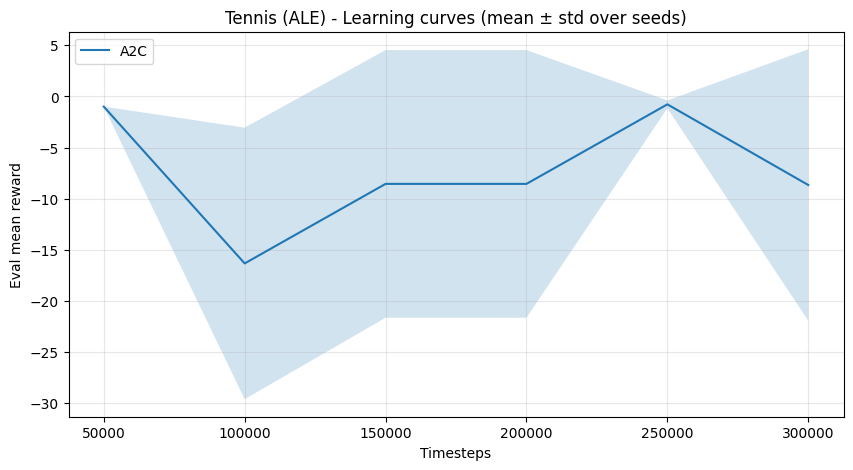

In [24]:
def plot_learning_curves(df):
    # Vérifier si le DataFrame est vide ou n'a pas la colonne 'algo'
    if df.empty:
        print("⚠️ Aucune donnée à afficher")
        return
    
    if "algo" not in df.columns:
        print("⚠️ Colonne 'algo' manquante dans le DataFrame")
        print(f"Colonnes disponibles: {df.columns.tolist()}")
        return
    
    plt.figure(figsize=(10,5))
    for algo in df["algo"].unique():
        sub = df[df["algo"] == algo].copy()
        # moyenne par timestep sur seeds
        g = sub.groupby("timesteps")["mean_reward"]
        mean = g.mean()
        std = g.std().fillna(0)
        plt.plot(mean.index, mean.values, label=algo)
        plt.fill_between(mean.index, (mean-std).values, (mean+std).values, alpha=0.2)
    plt.xlabel("Timesteps")
    plt.ylabel("Eval mean reward")
    plt.title("Tennis (ALE) - Learning curves (mean ± std over seeds)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curves(hist_df)


In [25]:
# Debug : afficher le contenu des données
print("all_hist:", all_hist)
print("\nhist_df shape:", hist_df.shape)
print("\nhist_df columns:", hist_df.columns.tolist() if not hist_df.empty else "DataFrame vide")
print("\nhist_df:")
print(hist_df)

all_hist: [{'timesteps': 50000, 'mean_reward': -1.0, 'std_reward': 0.0, 'seed': 0, 'algo': 'A2C'}, {'timesteps': 100000, 'mean_reward': -1.0, 'std_reward': 0.0, 'seed': 0, 'algo': 'A2C'}, {'timesteps': 150000, 'mean_reward': -1.0, 'std_reward': 0.0, 'seed': 0, 'algo': 'A2C'}, {'timesteps': 200000, 'mean_reward': -1.0, 'std_reward': 0.0, 'seed': 0, 'algo': 'A2C'}, {'timesteps': 250000, 'mean_reward': -1.0, 'std_reward': 0.0, 'seed': 0, 'algo': 'A2C'}, {'timesteps': 300000, 'mean_reward': -1.0, 'std_reward': 0.0, 'seed': 0, 'algo': 'A2C'}, {'timesteps': 50000, 'mean_reward': -1.0, 'std_reward': 0.0, 'seed': 1, 'algo': 'A2C'}, {'timesteps': 100000, 'mean_reward': -24.0, 'std_reward': 0.0, 'seed': 1, 'algo': 'A2C'}, {'timesteps': 150000, 'mean_reward': -23.666666666666668, 'std_reward': 0.4714045207910317, 'seed': 1, 'algo': 'A2C'}, {'timesteps': 200000, 'mean_reward': -23.666666666666668, 'std_reward': 0.4714045207910317, 'seed': 1, 'algo': 'A2C'}, {'timesteps': 250000, 'mean_reward': -1.

In [26]:
final_table = (
    sum_df.groupby("algo")
    .agg(
        final_mean_avg=("final_mean", "mean"),
        final_mean_std=("final_mean", "std"),
        final_std_avg=("final_std", "mean"),
        runs=("seed","count"),
    )
    .reset_index()
)

final_table

,algo,final_mean_avg,final_mean_std,final_std_avg,runs
0,A2C,-8.533333,13.396019,0.266667,3
